In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn import metrics 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('training_dataset.csv')
df1=pd.read_csv('testing_dataset.csv')

In [4]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1.0,2.0,0.0,892.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,0,1,3,0,3,0,2,0,0,...,1.0,2.0,1.0,9540.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,0,0,1,0,0,0,0,0,0,...,1.0,2.0,3.0,589.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0,2,5,0,0,0,0,0,0,...,1.0,2.0,0.0,292.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2,0,0,0,0,0,0,0,0,0,...,1.0,2.0,1.0,3597.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
df.describe(include='all')

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,58771.000000,...,58770.000000,58770.000000,58770.000000,58770.000000,58769.000000,58769.000000,58769.000000,58769.000000,58769.000000,58769.000000
mean,2.192816,0.332494,0.113985,1.283728,0.009188,0.207807,0.021967,0.141515,0.002688,0.001157,...,1.132891,2.771873,1.740599,6206.654399,0.505828,0.342851,0.001021,0.001838,0.005207,0.345675
std,1.226189,1.122767,0.644810,1.895239,0.116893,0.962466,0.255504,0.925634,0.077125,0.075378,...,0.893484,1.319455,1.706185,12087.141967,0.499970,0.785938,0.056851,0.063074,0.071971,0.475592
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2100.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10799.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df=df.fillna(0)
df1=df1.fillna(0)

In [7]:
# List of useful columns
useful_columns = [
    'qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length', 'qty_dot_directory',
    'qty_hyphen_directory', 'qty_slash_directory', 'directory_length', 'qty_dot_file',
    'qty_questionmark_file', 'file_length','email_in_url','qty_tld_url','qty_hyphen_url','phishing'

]
# Drop other columns from the DataFrame
df = df[useful_columns]
df1=df1[useful_columns]

In [8]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of qty_slash_url is : 2.115097532562723
The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_domain is : 2.4758556378265784
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of qty_hyphen_directory is : 5.7112456913556375
The skewness of qty_slash_directory is : 1.2778613383485702
The skewness of directory_length is : 11.397699820612969
The skewness of qty_dot_file is : 0.9602734996903586
The skewness of qty_questionmark_file is : 0.13640714535059223
The skewness of file_length is : 36.94724658452391
The skewness of email_in_url is : 7.126843588609052
The skewness of qty_tld_url is : 6.709775830871398
The skewness of qty_hyphen_url is : 7.830055099634531
The skewness of phishing is : 0.6490555084361906


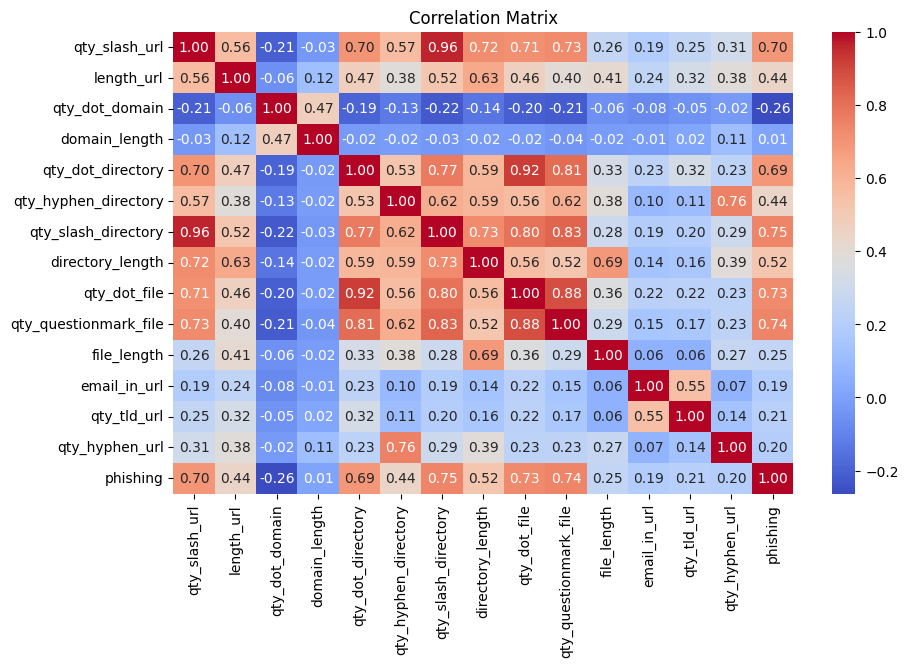

In [9]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [10]:
def impute_outliers(data, column):
    Q1 = data[column].quantile(0.10)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = data[column].mean()
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])
    return data

columns_to_check = ['email_in_url','qty_tld_url','qty_hyphen_url']
data=df.copy()
for column in columns_to_check:
    data = impute_outliers(data, column)

df=data

In [11]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of qty_slash_url is : 2.115097532562723
The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_domain is : 2.4758556378265784
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of qty_hyphen_directory is : 5.7112456913556375
The skewness of qty_slash_directory is : 1.2778613383485702
The skewness of directory_length is : 11.397699820612969
The skewness of qty_dot_file is : 0.9602734996903586
The skewness of qty_questionmark_file is : 0.13640714535059223
The skewness of file_length is : 36.94724658452391
The skewness of email_in_url is : 7.1268435886090575
The skewness of qty_tld_url is : 4.292907831649265
The skewness of qty_hyphen_url is : 2.519491964641667
The skewness of phishing is : 0.6490555084361906


In [12]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of qty_slash_url is : 2.115097532562723
The skewness of length_url is : 17.3634117972455
The skewness of qty_dot_domain is : 2.4758556378265784
The skewness of domain_length is : 3.358949423089712
The skewness of qty_dot_directory is : 2.2810552805352122
The skewness of qty_hyphen_directory is : 5.7112456913556375
The skewness of qty_slash_directory is : 1.2778613383485702
The skewness of directory_length is : 11.397699820612969
The skewness of qty_dot_file is : 0.9602734996903586
The skewness of qty_questionmark_file is : 0.13640714535059223
The skewness of file_length is : 36.94724658452391
The skewness of email_in_url is : 7.1268435886090575
The skewness of qty_tld_url is : 4.292907831649265
The skewness of qty_hyphen_url is : 2.519491964641667
The skewness of phishing is : 0.6490555084361906


In [13]:
df.head()

,qty_slash_url,length_url,qty_dot_domain,domain_length,qty_dot_directory,qty_hyphen_directory,qty_slash_directory,directory_length,qty_dot_file,qty_questionmark_file,file_length,email_in_url,qty_tld_url,qty_hyphen_url,phishing
0,1,25,2,17,1,0,1,8,1,0.0,7.0,0.0,1.000000,0.0,1.0
1,3,223,2,16,3,0,3,42,1,0.0,9.0,0.0,1.047234,0.0,1.0
2,1,15,2,14,0,0,1,1,0,0.0,0.0,0.0,1.000000,0.0,0.0
3,5,81,2,19,2,0,5,62,1,0.0,9.0,0.0,1.000000,0.0,1.0
4,0,19,2,19,-1,-1,-1,-1,-1,-1.0,-1.0,0.0,1.000000,0.0,0.0


In [14]:
df1.columns

Index(['qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_slash_directory',
       'directory_length', 'qty_dot_file', 'qty_questionmark_file',
       'file_length', 'email_in_url', 'qty_tld_url', 'qty_hyphen_url',
       'phishing'],
      dtype='object')

In [15]:

# Creating holders to store the model performance results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))

In [16]:
x_train=df.drop(['phishing'],axis=1).values
y_train=df['phishing'].values

In [17]:
x_test=df1.drop(['phishing'],axis=1).values
y_test=df1['phishing'].values

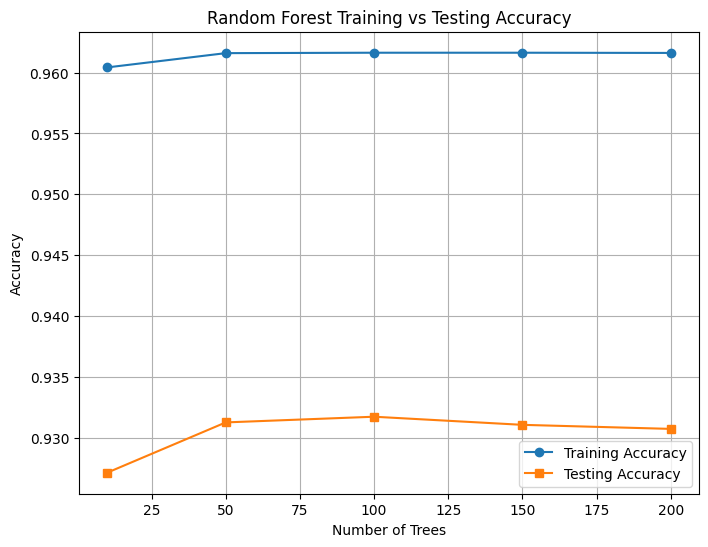

In [18]:
# Lists to store accuracy
n_estimators = [10, 50, 100, 150, 200]
train_accuracies = []
test_accuracies = []

# Train Random Forest with varying number of trees
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42, bootstrap=True)
    rf.fit(x_train, y_train)
    
    # Accuracy on training and test sets
    train_acc = accuracy_score(y_train, rf.predict(x_train))
    test_acc = accuracy_score(y_test, rf.predict(x_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(n_estimators, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
RF=RandomForestClassifier(n_estimators=100,random_state=42)
RF_Model=RF.fit(x_train,y_train)

In [20]:
y_test.shape

(14999,)

In [21]:
y_pred=RF_Model.predict(x_test)

In [22]:
y_train_forest = RF_Model.predict(x_train)

In [23]:
y_pred.shape

(14999,)

In [24]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9794
           1       0.92      0.88      0.90      5205

    accuracy                           0.93     14999
   macro avg       0.93      0.92      0.92     14999
weighted avg       0.93      0.93      0.93     14999



In [25]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_pred)
print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))
print()

f1_score_train_forest = metrics.f1_score(y_train,y_train_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_pred)
print("Random Forest : f1_score on training Data: {:.3f}".format(f1_score_train_forest))
print("Random Forest : f1_score on test Data: {:.3f}".format(f1_score_test_forest))
print()

recall_score_train_forest = metrics.recall_score(y_train,y_train_forest)
recall_score_test_forest = metrics.recall_score(y_test,y_pred)
print("Random Forest : Recall on training Data: {:.3f}".format(recall_score_train_forest))
print("Random Forest : Recall on test Data: {:.3f}".format(recall_score_test_forest))
print()

precision_score_train_forest = metrics.precision_score(y_train,y_train_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_pred)
print("Random Forest : precision on training Data: {:.3f}".format(precision_score_train_forest))
print("Random Forest : precision on test Data: {:.3f}".format(precision_score_test_forest))

Random Forest : Accuracy on training Data: 0.962
Random Forest : Accuracy on test Data: 0.932

Random Forest : f1_score on training Data: 0.943
Random Forest : f1_score on test Data: 0.899

Random Forest : Recall on training Data: 0.913
Random Forest : Recall on test Data: 0.877

Random Forest : precision on training Data: 0.975
Random Forest : precision on test Data: 0.923


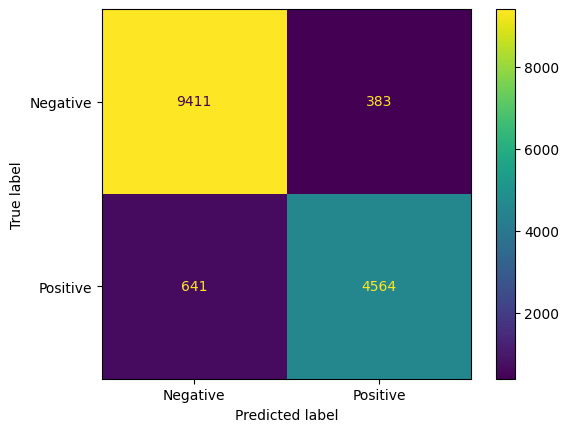

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

In [27]:
with open("phishing_detection_model.pkl", "wb") as file:
    pickle.dump(RF_Model, file)
print("Model saved successfully!")

Model saved successfully!


In [28]:
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(n_estimators=100,random_state=42)

# fit the model 
XG_Model= xgb.fit(x_train,y_train)

In [29]:

#predicting the target value from the model for the samples
y_train_xgb = xgb.predict(x_train)
y_test_xgb = xgb.predict(x_test)

In [30]:
report = classification_report(y_test, y_test_xgb)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9794
           1       0.91      0.88      0.89      5205

    accuracy                           0.93     14999
   macro avg       0.92      0.92      0.92     14999
weighted avg       0.93      0.93      0.93     14999



In [31]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_xgb = metrics.accuracy_score(y_train,y_train_xgb)
acc_test_xgb = metrics.accuracy_score(y_test,y_test_xgb)
print("XGBoost Classifier : Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost Classifier : Accuracy on test Data: {:.3f}".format(acc_test_xgb))
print()

f1_score_train_xgb = metrics.f1_score(y_train,y_train_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
print("XGBoost Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_xgb))
print("XGBoost Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_xgb))
print()

recall_score_train_xgb = metrics.recall_score(y_train,y_train_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
print("XGBoost Classifier : Recall on training Data: {:.3f}".format(recall_score_train_xgb))
print("XGBoost Classifier : Recall on test Data: {:.3f}".format(recall_score_train_xgb))
print()

precision_score_train_xgb = metrics.precision_score(y_train,y_train_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
print("XGBoost Classifier : precision on training Data: {:.3f}".format(precision_score_train_xgb))
print("XGBoost Classifier : precision on test Data: {:.3f}".format(precision_score_train_xgb))

XGBoost Classifier : Accuracy on training Data: 0.941
XGBoost Classifier : Accuracy on test Data: 0.928

XGBoost Classifier : f1_score on training Data: 0.913
XGBoost Classifier : f1_score on test Data: 0.894

XGBoost Classifier : Recall on training Data: 0.900
XGBoost Classifier : Recall on test Data: 0.900

XGBoost Classifier : precision on training Data: 0.927
XGBoost Classifier : precision on test Data: 0.927


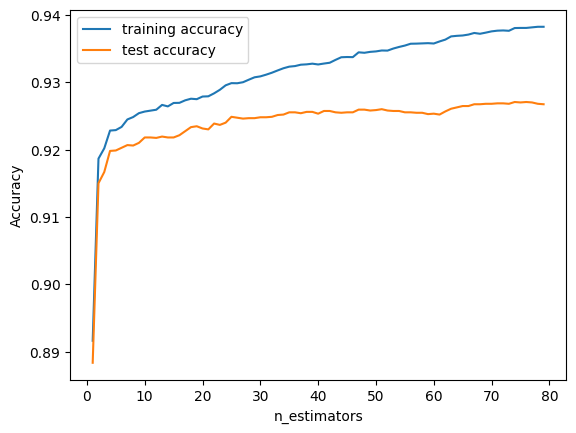

In [32]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 20
depth = range(1,80)
for n in depth:
    xgb_test =  XGBClassifier(n_estimators=n)

    xgb_test.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(xgb_test.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy.append(xgb_test.score(x_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_estimators")
plt.legend()

In [33]:

#storing the results. The below mentioned order of parameter passing is important.

storeResults('Random Forest',acc_test_forest,f1_score_test_forest,
             recall_score_train_forest,precision_score_train_forest)

In [34]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('XGBoost Classifier',acc_test_xgb,f1_score_test_xgb,
             recall_score_train_xgb,precision_score_train_xgb)

In [35]:
# Train model using naive bayes classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
NB_Model = nb.fit(x_train, y_train)


In [36]:
#predicting the target value from the model for the samples
y_train_naive = nb.predict(x_train)
y_test_naive = nb.predict(x_test)


In [37]:
report = classification_report(y_test, y_test_naive)

print(report)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      9794
           1       0.85      0.82      0.83      5205

    accuracy                           0.88     14999
   macro avg       0.88      0.87      0.87     14999
weighted avg       0.88      0.88      0.88     14999



In [38]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_naive = metrics.accuracy_score(y_train,y_train_naive)
acc_test_naive = metrics.accuracy_score(y_test,y_test_naive)
print("Naive Bayes Classifier : Accuracy on training Data: {:.3f}".format(acc_train_naive))
print("Naive Bayes Classifier : Accuracy on test Data: {:.3f}".format(acc_test_naive))
print()

f1_score_train_naive = metrics.f1_score(y_train,y_train_naive)
f1_score_test_naive = metrics.f1_score(y_test,y_test_naive)
print("Naive Bayes Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_naive))
print("Naive Bayes Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_naive))
print()

recall_score_train_naive = metrics.recall_score(y_train,y_train_naive)
recall_score_test_naive = metrics.recall_score(y_test,y_test_naive)
print("Naive Bayes Classifier : Recall on training Data: {:.3f}".format(recall_score_train_naive))
print("Naive Bayes Classifier : Recall on test Data: {:.3f}".format(recall_score_train_naive))
print()

precision_score_train_naive = metrics.precision_score(y_train,y_train_naive)
precision_score_test_naive = metrics.precision_score(y_test,y_test_naive)
print("Naive Bayes Classifier : precision on training Data: {:.3f}".format(precision_score_train_naive))
print("Naive Bayes Classifier : precision on test Data: {:.3f}".format(precision_score_train_naive))

Naive Bayes Classifier : Accuracy on training Data: 0.887
Naive Bayes Classifier : Accuracy on test Data: 0.885

Naive Bayes Classifier : f1_score on training Data: 0.834
Naive Bayes Classifier : f1_score on test Data: 0.831

Naive Bayes Classifier : Recall on training Data: 0.825
Naive Bayes Classifier : Recall on test Data: 0.825

Naive Bayes Classifier : precision on training Data: 0.843
Naive Bayes Classifier : precision on test Data: 0.843


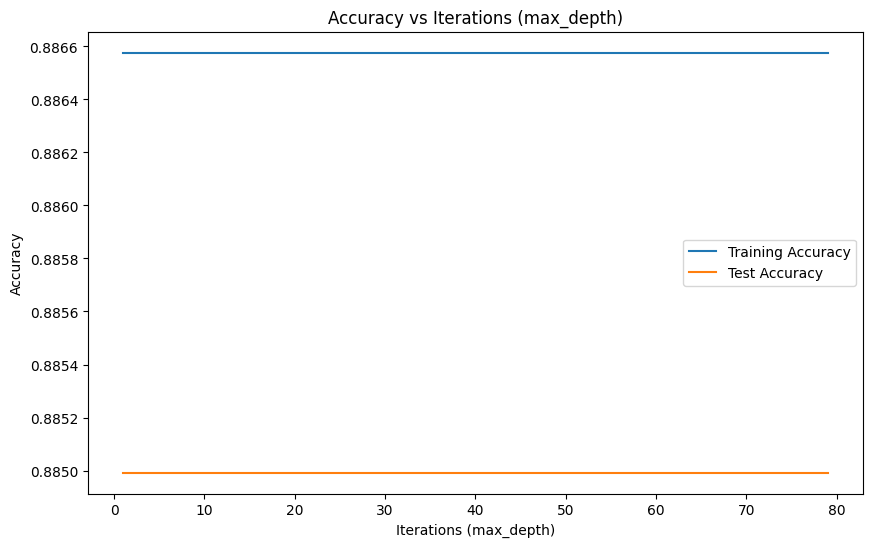

In [39]:
# Initialize lists for accuracies
training_accuracy = []
test_accuracy = []

# Try varying the 'max_depth' from 1 to 80 (adjust range as needed)
depth = range(1, 80)

for n in depth:
    gaussian_test = GaussianNB()

    # Fit the model
    gaussian_test.fit(x_train, y_train)

    # Record training accuracy
    training_accuracy.append(gaussian_test.score(x_train, y_train))

    # Record test accuracy
    test_accuracy.append(gaussian_test.score(x_test, y_test))

# Plotting the training & testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(depth, training_accuracy, label="Training Accuracy")
plt.plot(depth, test_accuracy, label="Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Iterations (max_depth)")
plt.legend()
plt.title("Accuracy vs Iterations (max_depth)")
plt.show()

In [40]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Naive Bayes Classifier',acc_test_naive,f1_score_test_naive,
             recall_score_train_naive,precision_score_train_naive)

In [41]:

#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1_score,
                        'Recall'   : recall,
                        'Precision': precision,
                      })

In [42]:
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,Random Forest,0.932,0.899,0.913,0.975
1,XGBoost Classifier,0.928,0.894,0.900,0.927
2,Naive Bayes Classifier,0.885,0.831,0.825,0.843
